<a href="https://colab.research.google.com/github/KULL-Centre/_2023_Pesce_IDPdesign/blob/main/IDPDesigner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**General information**

This Colab notebook enables to design sequence of IDPs with target scaling exponents ($\nu$).

The user needs to provide as input a starting sequence and a target value for $\nu$. The starting sequence can be evolved with swap moves or single point mutations.

If you use this notebook, please cite:
1. Pesce, F., Bremer, A., Tesei, G., Hopkins, J. B., Grace, C. R., Mittag, T., & Lindorff-Larsen, K. (2023). __Design of intrinsically disordered protein variants with diverse structural properties__. _bioRxiv_. DOI: https://doi.org/10.1101/2023.10.22.563461
2. Tesei, G., Trolle, A. I., Jonsson, N., Betz, J., Knudsen, F. E., Pesce, F., ... & Lindorff-Larsen, K. (2024). __Conformational ensembles of the human intrinsically disordered proteome__. _Nature, 626(8000), 897-904_. DOI: https://doi.org/10.1038/s41586-023-07004-5

In [1]:
#@title <b>Preliminary operations (i)</b>
import random
import subprocess
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import itertools
from joblib import dump, load
# subprocess.run( 'pip install wget localcider==0.1.18'.split() )
# subprocess.run('pip uninstall scikit-learn -y'.split())
# subprocess.run('pip install scikit-learn==1.0.2'.split())
import wget
from localcider.sequenceParameters import SequenceParameters
import matplotlib.pyplot as plt
# from google.colab import files
from ipywidgets import IntProgress
from IPython.display import display
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

url = 'https://github.com/KULL-Centre/_2023_Tesei_IDRome/blob/main'
if os.path.exists('svr_model_nu.joblib') == False:
  wget.download(url+'/svr_models/svr_model_nu.joblib?raw=true')
if os.path.exists('residues.csv') == False:
  wget.download(url+'/md_simulations/data/residues.csv?raw=true')

def calc_seq_prop(seq,residues,pH=7.):
    seq = list(seq).copy()
    fasta_kappa = np.array(seq.copy())
    N = len(seq)
    r = residues.copy()

    # calculate properties that do not depend on charges
    fK = sum([seq.count(a) for a in ['K']])/N
    fR = sum([seq.count(a) for a in ['R']])/N
    fE = sum([seq.count(a) for a in ['E']])/N
    fD = sum([seq.count(a) for a in ['D']])/N
    faro = sum([seq.count(a) for a in ['W','Y','F']])/N
    mean_lambda = np.mean(r.loc[seq].lambdas)

    pairs = np.array(list(itertools.combinations(seq,2)))
    pairs_indices = np.array(list(itertools.combinations(range(N),2)))
    # calculate sequence separations
    ij_dist = np.diff(pairs_indices,axis=1).flatten().astype(float)
    # calculate lambda sums
    ll = r.lambdas.loc[pairs[:,0]].values+r.lambdas.loc[pairs[:,1]].values
    # calculate SHD
    beta = -1
    shd = np.sum(ll*np.power(np.abs(ij_dist),beta))/N

    # fix charges
    r.loc['X'] = r.loc[seq[0]]
    r.loc['X','q'] = r.loc[seq[0],'q'] + 1.
    seq[0] = 'X'
    if r.loc['X','q'] > 0:
        fasta_kappa[0] = 'K'
    else:
        fasta_kappa[0] = 'A'
    r.loc['Z'] = r.loc[seq[-1]]
    r.loc['Z','q'] = r.loc[seq[-1],'q'] - 1.
    seq[-1] = 'Z'
    if r.loc['Z','q'] < 0:
        fasta_kappa[-1] = 'D'
    else:
        fasta_kappa[-1] = 'A'
    Hc = 1/(1+10**(pH-6))
    if Hc < 0.5:
        r.loc['H', 'q'] = 0
        fasta_kappa[np.where(np.array(seq) == 'H')[0]] = 'A'
    elif Hc >= 0.5:
        r.loc['H', 'q'] = 1
        fasta_kappa[np.where(np.array(seq) == 'H')[0]] = 'K'

    # calculate properties that depend on charges
    pairs = np.array(list(itertools.combinations(seq,2)))
    # calculate charge products
    qq = r.q.loc[pairs[:,0]].values*r.q.loc[pairs[:,1]].values
    # calculate SCD
    scd = np.sum(qq*np.sqrt(ij_dist))/N
    SeqOb = SequenceParameters(''.join(fasta_kappa))
    kappa = SeqOb.get_kappa()
    omega_aro = SeqOb.get_kappa_X(grp1=['Y','F','W'])
    fcr = r.q.loc[seq].abs().mean()
    ncpr = r.q.loc[seq].mean()

    return pd.Series(data=[fK,fR,fE,fD,faro,scd,shd,kappa,omega_aro,fcr,mean_lambda,ncpr],
                 index=['fK','fR','fE','fD','faro','SCD','SHD','kappa','omega_aro','FCR','mean_lambda','NCPR'])

In [2]:
#@title <b>Preliminary operations (ii)</b>
class Sequence:
  aa = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
  def __init__(self, start_seq=None, length=None, pH=7.):
    assert start_seq is not None or length is not None, "Either initialize a starting sequence or specify a sequence length so that a random sequence is initialized!"
    self.pH = pH
    if start_seq is None and length is not None:
      self.sequence = random.choices(self.aa, k=length)
    else:
      self.sequence = list(start_seq)
    self.length = len(self.sequence)

    self.residues = pd.read_csv('residues.csv').set_index('one')
    self.model_nu = load('svr_model_nu.joblib')

  def get_sequence(self):
    return ''.join(self.sequence)

  def mutate(self, mode):
    if mode == 'single_point':
      self.sequence[random.randrange(len(self.sequence))] = random.choices(self.aa, k=1)[0]
    if mode == 'swap_full':
      a, b = random.randrange(len(self.sequence)), random.randrange(len(self.sequence))
      self.sequence[b], self.sequence[a] = self.sequence[a], self.sequence[b]
    if mode == 'swap_expr':
      a, b = random.randrange(1,len(self.sequence)), random.randrange(1,len(self.sequence))
      self.sequence[b], self.sequence[a] = self.sequence[a], self.sequence[b]

  def featurizer(self):
    self.features = calc_seq_prop(self.sequence,self.residues,self.pH)

  def get_nu(self):
    features_nu = ['SCD','SHD','kappa','FCR','mean_lambda']
    self.featurizer()
    return self.model_nu.predict(self.features.loc[features_nu].values.reshape(1, -1))[0]


class MCMC(Sequence):
  def __init__(self, mutation_mode, nu_target, start_seq=None, length=None, pH=7., c=0.003):
    super().__init__(start_seq, length, pH)
    self.memory = pd.DataFrame(columns=['fasta','nu','mc'])
    self.memory.loc[0] = dict(fasta=self.sequence.copy(),
                        nu=self.get_nu(),
                        mc=True)
    self.Features = pd.DataFrame(columns=['fK','fR','fE','fD','faro','SCD','SHD','kappa','omega_aro','FCR','mean_lambda','NCPR'])
    self.Features.loc[0] = self.features.copy()
    self.mode = mutation_mode
    self.nu_target = nu_target
    self.c = c

  def step(self):
    self.mutate(mode = self.mode)
    self.memory.loc[self.memory.index.values[-1]+1] = dict(fasta=self.sequence.copy(),nu=self.get_nu(),mc=None)
    self.Features.loc[self.Features.index.values[-1]+1] = self.features.copy()
    lastmc = self.memory[(self.memory['mc']==True)].index[-1]
    L = abs(self.memory.nu[self.memory.index.values[-1]] - self.nu_target) - abs(self.memory.nu[lastmc] - self.nu_target)

    self.memory.mc[self.memory.index.values[-1]] = np.exp(L/-self.c) > random.random()

    if self.memory.mc[self.memory.index.values[-1]] == False:
      self.sequence = self.memory.fasta[lastmc].copy()
    if len(self.memory) % (self.length*2) == 0:
      self.c = self.c*0.99

In [3]:
import sklearn
#@title <b>Input sequence and parameters</b>
NAME = "Q9UHJ3_down" #@param {type:"string"}
SEQUENCE = "VLTKTKYTHYYGKKKNKRIGRPPGGHSNLACALKKASKRRKRRKNVFVHKKKRSSASVDNTPAGSPQGSGGEDEDDPDEGDDDSLSEGSTSEQQDELQEESEMSEKKSCSSSPTQSEISTSLPPDRQRRKRELRTFSFSDDENKPPSPKEIRIEVAERLHLD" #@param {type:"string"}
nu_TARGET = 0.3 #@param {type:"number"}
MUTATION_TYPE = 'swap_full' # @param ["swap_full", "swap_expr", "single_point"]
CONTROL_PARAMETER = 0.00002 #@param {type:"number"}

if " " in SEQUENCE:
    SEQUENCE = ''.join(SEQUENCE.split())

evo = MCMC(start_seq = SEQUENCE, mutation_mode=MUTATION_TYPE, nu_target=nu_TARGET, c=CONTROL_PARAMETER)

Acceptance rate: 0.2843578210894553


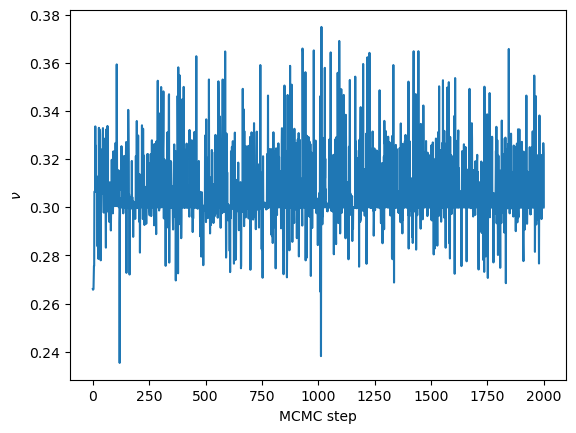

In [4]:
#@title <b>Evolve</b>
STEPS = 2000 #@param {type:"number"}

f = IntProgress(min=0, max=STEPS, description='Progress:', bar_style='warning')
display(f)
for i in range(STEPS):
  evo.step()
  f.value += 1
clear_output()

acc_rate = sum(evo.memory.mc.values)/len(evo.memory)
print(f'Acceptance rate: {acc_rate}')

plt.plot(evo.memory.nu.values)
plt.xlabel('MCMC step')
plt.ylabel(r'$\nu$')
plt.show()

In [5]:
#@title <b>Sequence features</b>
evo.Features

,fK,fR,fE,fD,faro,SCD,SHD,kappa,omega_aro,FCR,mean_lambda,NCPR
0,0.117284,0.08642,0.098765,0.080247,0.037037,-8.619892,3.614917,0.428437,1.587598,0.395062,0.388887,0.024691
1,0.117284,0.08642,0.098765,0.080247,0.037037,-8.619892,3.608682,0.428437,1.587598,0.395062,0.388887,0.024691
2,0.117284,0.08642,0.098765,0.080247,0.037037,-8.619892,3.614917,0.428437,1.587598,0.395062,0.388887,0.024691
3,0.117284,0.08642,0.098765,0.080247,0.037037,-8.619892,3.614976,0.428437,1.587598,0.395062,0.388887,0.024691
4,0.117284,0.08642,0.098765,0.080247,0.037037,-8.581543,3.613060,0.419007,1.587598,0.395062,0.388887,0.024691
...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0.117284,0.08642,0.098765,0.080247,0.037037,-8.498132,3.611902,0.361485,1.430198,0.395062,0.388887,0.024691
1997,0.117284,0.08642,0.098765,0.080247,0.037037,-8.498132,3.616376,0.361485,1.321788,0.395062,0.388887,0.024691
1998,0.117284,0.08642,0.098765,0.080247,0.037037,-7.563136,3.611693,0.341521,1.430198,0.395062,0.388887,0.024691
1999,0.117284,0.08642,0.098765,0.080247,0.037037,-7.711587,3.611488,0.345647,1.430198,0.395062,0.388887,0.024691


In [ ]:
#@title <b>Download results</b>
out = evo.Features.copy()
out['fasta'] = [''.join(i) for i in evo.memory.fasta.values]
out['nu'] = evo.memory.nu
out.to_csv(f'{NAME}_designs.csv')
# files.download(f'{NAME}_designs.csv')